# Using LeNet5 for Variational Auto-Encoding (VAE)

In [29]:
import torch
import torchvision
import numpy as np

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

## Loading dataset from MNIST 32

In [31]:
import torchvision.transforms.functional


transform = transforms.Compose([
    transforms.RandomResizedCrop((32,32), (0.75,1)),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3,sigma=0.1),

])     # Set mean to 0 and  var to 1

images, labels = torch.load('./.data/MNIST32_train.pkl')
#images = transform(images) 
# images = torchvision.transforms.functional.adjust_contrast(images, 2.0)


all_train = torch.utils.data.TensorDataset(images, labels) 
train_size = int(0.9 * len(all_train))
val_size = len(all_train) - train_size

train_set, val_set = torch.utils.data.random_split(all_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

images, labels = torch.load('./.data/MNIST32_val.pkl')
#images = transform(images) 
# images = torchvision.transforms.functional.adjust_contrast(images, 2.0)

test_data = torch.utils.data.TensorDataset(images, labels)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

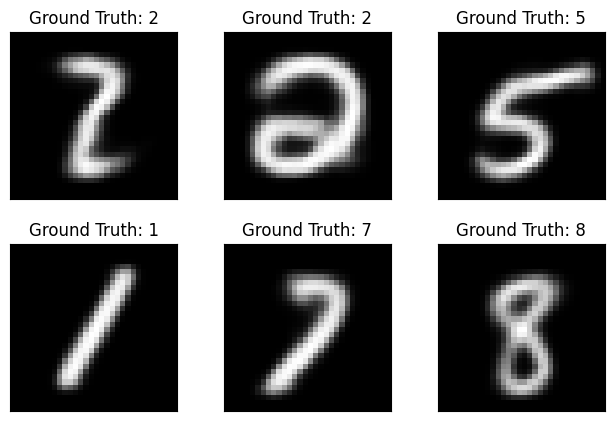

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i+16][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i+16]))
  plt.xticks([])
  plt.yticks([])

plt.show()

## Creating the model

In [33]:
from sympy import false


class LeNetVAE(nn.Module):
    def __init__(self, device = None):
        super(LeNetVAE, self).__init__()
        # LeNet5 = torch.load(".checkpoint/model_checkpoint.pt", weights_only=False)
        # self.encoder = nn.Sequential(*list(LeNet5.children())[:11])

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 0),  # Extracts feautres     -> 28x28x6
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),     # Reduce dimensionality -> 14x14x6

            nn.Conv2d(6, 16, kernel_size = 5, stride = 1, padding = 0), # Extracts feautres     -> 10x10x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),     # Reduce dimensionality -> 5x5x16

            nn.Flatten(),       # 5x5x16 -> 400

            nn.Linear(400, 120),# Fully connected layer
            nn.ReLU(),
            nn.Linear(120, 84), # Fully connected layer
            nn.ReLU()
        )

        # # Congela i parametri
        # for param in self.encoder.parameters():
        #     param.requires_grad = False

        self.mean_layer = nn.Linear(84, 2)
        self.logvar_layer = nn.Linear(84,2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 84),
            nn.ReLU(),
            nn.Linear(84, 120),
            nn.ReLU(),
            nn.Linear(120,400),
            nn.ReLU(),
            nn.Unflatten(1, (16, 5, 5)),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid()
        )

        self.device_type = device

        self.to(device, non_blocking=True)

    def encode(self, x):
        latent = self.encoder(x)
        mean, logvar = self.mean_layer(latent), self.logvar_layer(latent)
        return mean, logvar
    
    def sample(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.sample(mean, logvar)
        out = self.decode(z)
        return out, mean, logvar
        


model = LeNetVAE(device)

In [34]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [35]:
def loss_function(y, x, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x, y, reduction="sum")
    KLD = - 0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KLD

## Training the model

In [36]:
# this code is taken from https://github.com/Bjarten/early-stopping-pytorch
# Copyright (c) 2018 Bjarte Mehus Sunde under MIT License
# to see full license consult the NOTICE.txt file on the Github repository from which this notebook is taken from

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0


  def save_checkpoint(self, model):
    torch.save(model, self.path)

In [37]:
EPOCHS = 100
train_loss = []
val_loss = []
# train_acc = []
# val_acc = []



early_stopper = EarlyStopping(patience = 5, path=".checkpoint/transfer.pt")

for epoch in range(EPOCHS):
    model.train()
    tloss = 0
    tacc = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device, non_blocking = True)

        pred = model(x)

        loss = loss_function(x, *pred)

        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()

        tloss += loss.detach()

    train_loss.append(tloss/len(train_loader))
    # train_acc.append(tacc/len(train_loader))

    model.eval()
    tloss = 0
    tacc = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(val_loader):
            x = x.to(device, non_blocking = True)

            pred = model(x)

            loss = loss_function(x, *pred)

            tloss += loss.detach()
    
    val_loss.append(tloss/len(val_loader))
    # val_acc.append(tacc/len(val_loader))

    early_stopper(val_loss[-1], model)
    print(f"Epoch {epoch + 1}: \nTrain Loss = {train_loss[-1]:3f}, Validation Loss = {val_loss[-1]:3f}")
    # print(f"Train Acc = {train_acc[-1]:-5f}, Validation Acc = {val_acc[-1]:-5f}")
    if early_stopper.early_stop:
      print("Early stopping triggered.")
      break

Epoch 1: 
Train Loss = 37919.867188, Validation Loss = 32351.171875
Epoch 2: 
Train Loss = 31461.361328, Validation Loss = 29911.714844
Epoch 3: 
Train Loss = 29253.882812, Validation Loss = 28534.824219
Epoch 4: 
Train Loss = 28376.964844, Validation Loss = 28009.744141
Epoch 5: 
Train Loss = 27923.853516, Validation Loss = 27683.066406
Epoch 6: 
Train Loss = 27626.425781, Validation Loss = 27534.904297
Epoch 7: 
Train Loss = 27396.748047, Validation Loss = 27328.876953
Epoch 8: 
Train Loss = 27226.386719, Validation Loss = 27056.597656
Epoch 9: 
Train Loss = 27064.460938, Validation Loss = 26889.751953
Epoch 10: 
Train Loss = 26923.882812, Validation Loss = 26839.982422
Epoch 11: 
Train Loss = 26795.482422, Validation Loss = 26737.974609
Epoch 12: 
Train Loss = 26684.742188, Validation Loss = 26580.091797
Epoch 13: 
Train Loss = 26539.724609, Validation Loss = 26482.087891
Epoch 14: 
Train Loss = 26484.052734, Validation Loss = 26340.708984
Epoch 15: 
Train Loss = 26388.154297, Valid

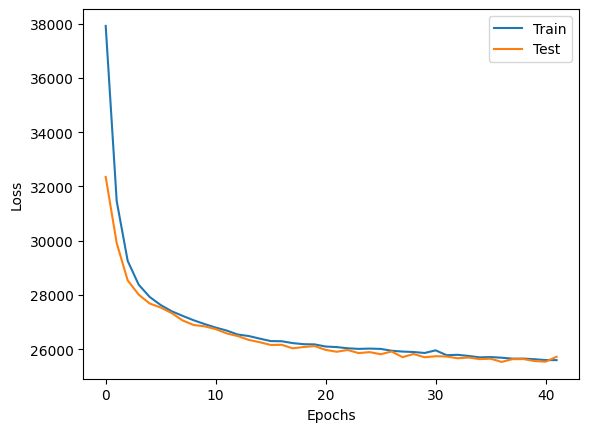

In [38]:
import matplotlib.pyplot as plt
train_loss = [it.cpu() for it in train_loss]
tloss = [it.cpu() for it in val_loss]
plt.plot(train_loss, label = "Train")
plt.plot(tloss, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [39]:
model.eval()
tloss = 0
tacc = 0
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.to(device, non_blocking = True)
        pred = model(x)

        loss = loss_function(x, *pred)

        tloss += loss.detach()

tloss = (tloss/len(test_loader))
tacc = (tacc/len(test_loader))
print(f"Test Loss = {tloss:-5f}")

Test Loss = 25544.597656


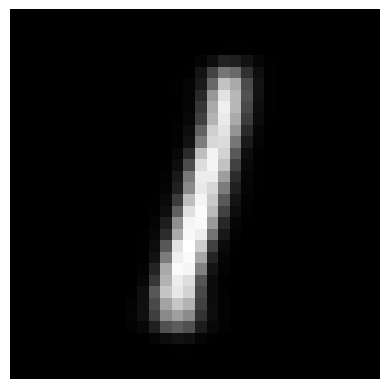

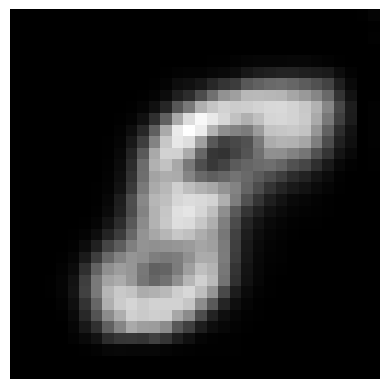

(None, None)

In [40]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(32, 32) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.6, -1.9), generate_digit(1.0, 0.0)

/tmp/ipykernel_25939/3071634007.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


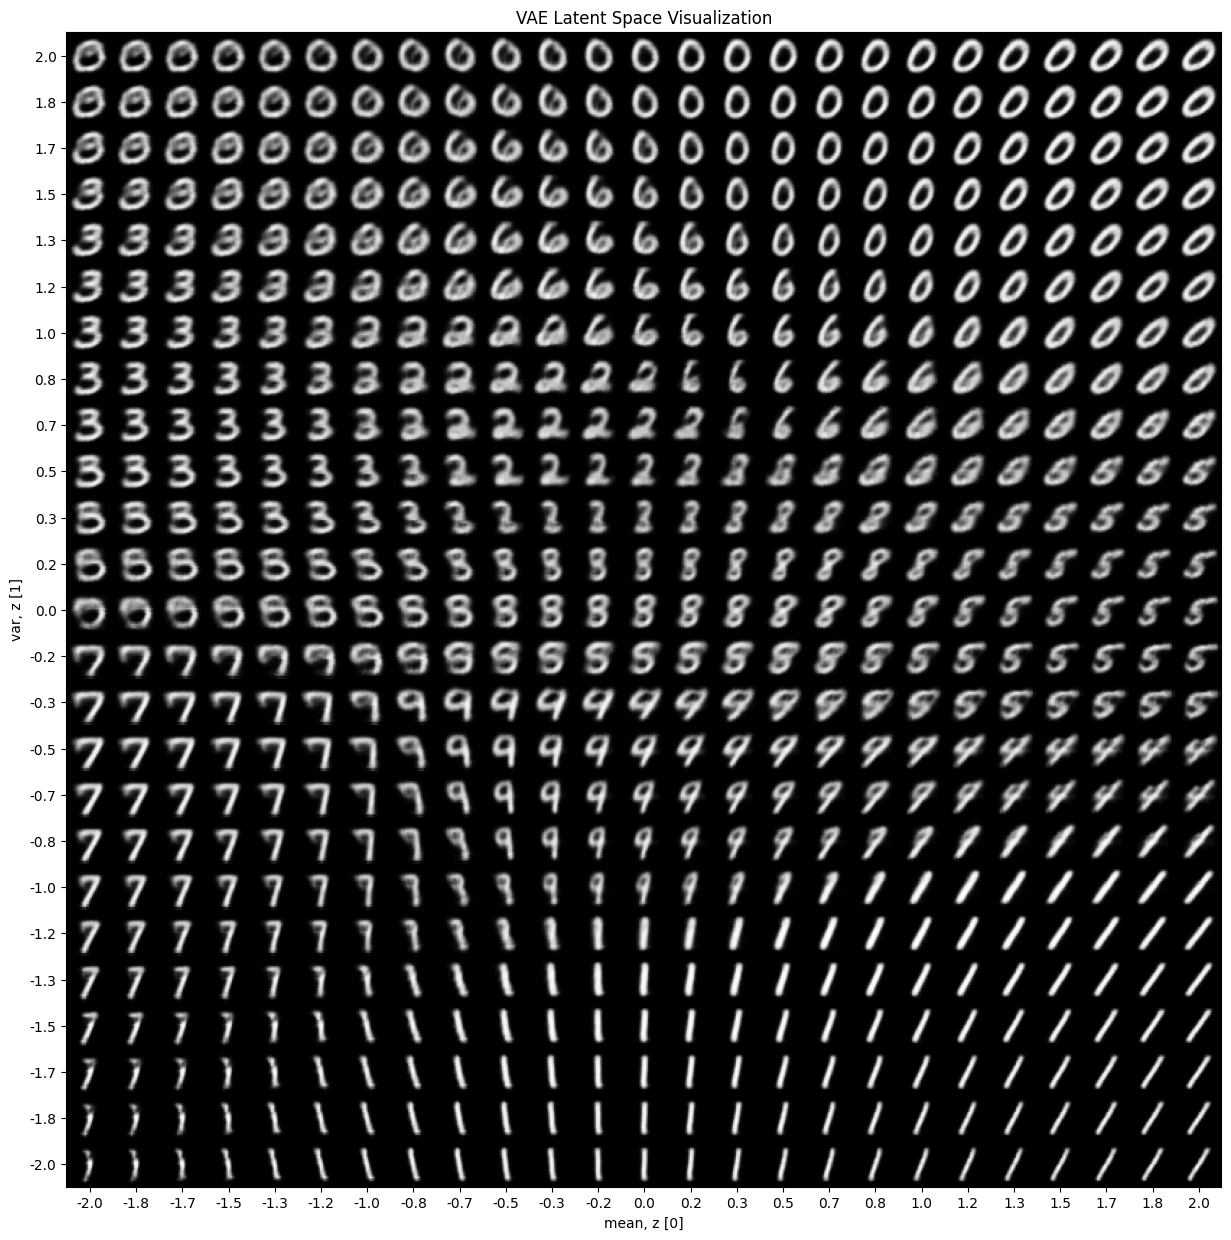

In [41]:
from matplotlib import cm
from torch import softmax
import matplotlib.patches as mpatches

LeNet5 = torch.load(".checkpoint/model_checkpoint.pt",weights_only=False)

def plot_latent_space(model, scale=1.0, n=25, digit_size=32, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()




plot_latent_space(model,n = 25 , scale=2)

/home/claudio/Documenti/Code/DeepLearning/tf/lib/python3.12/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/tmp/ipykernel_25939/1557240665.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")
/tmp/ipykernel_25939/1557240665.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


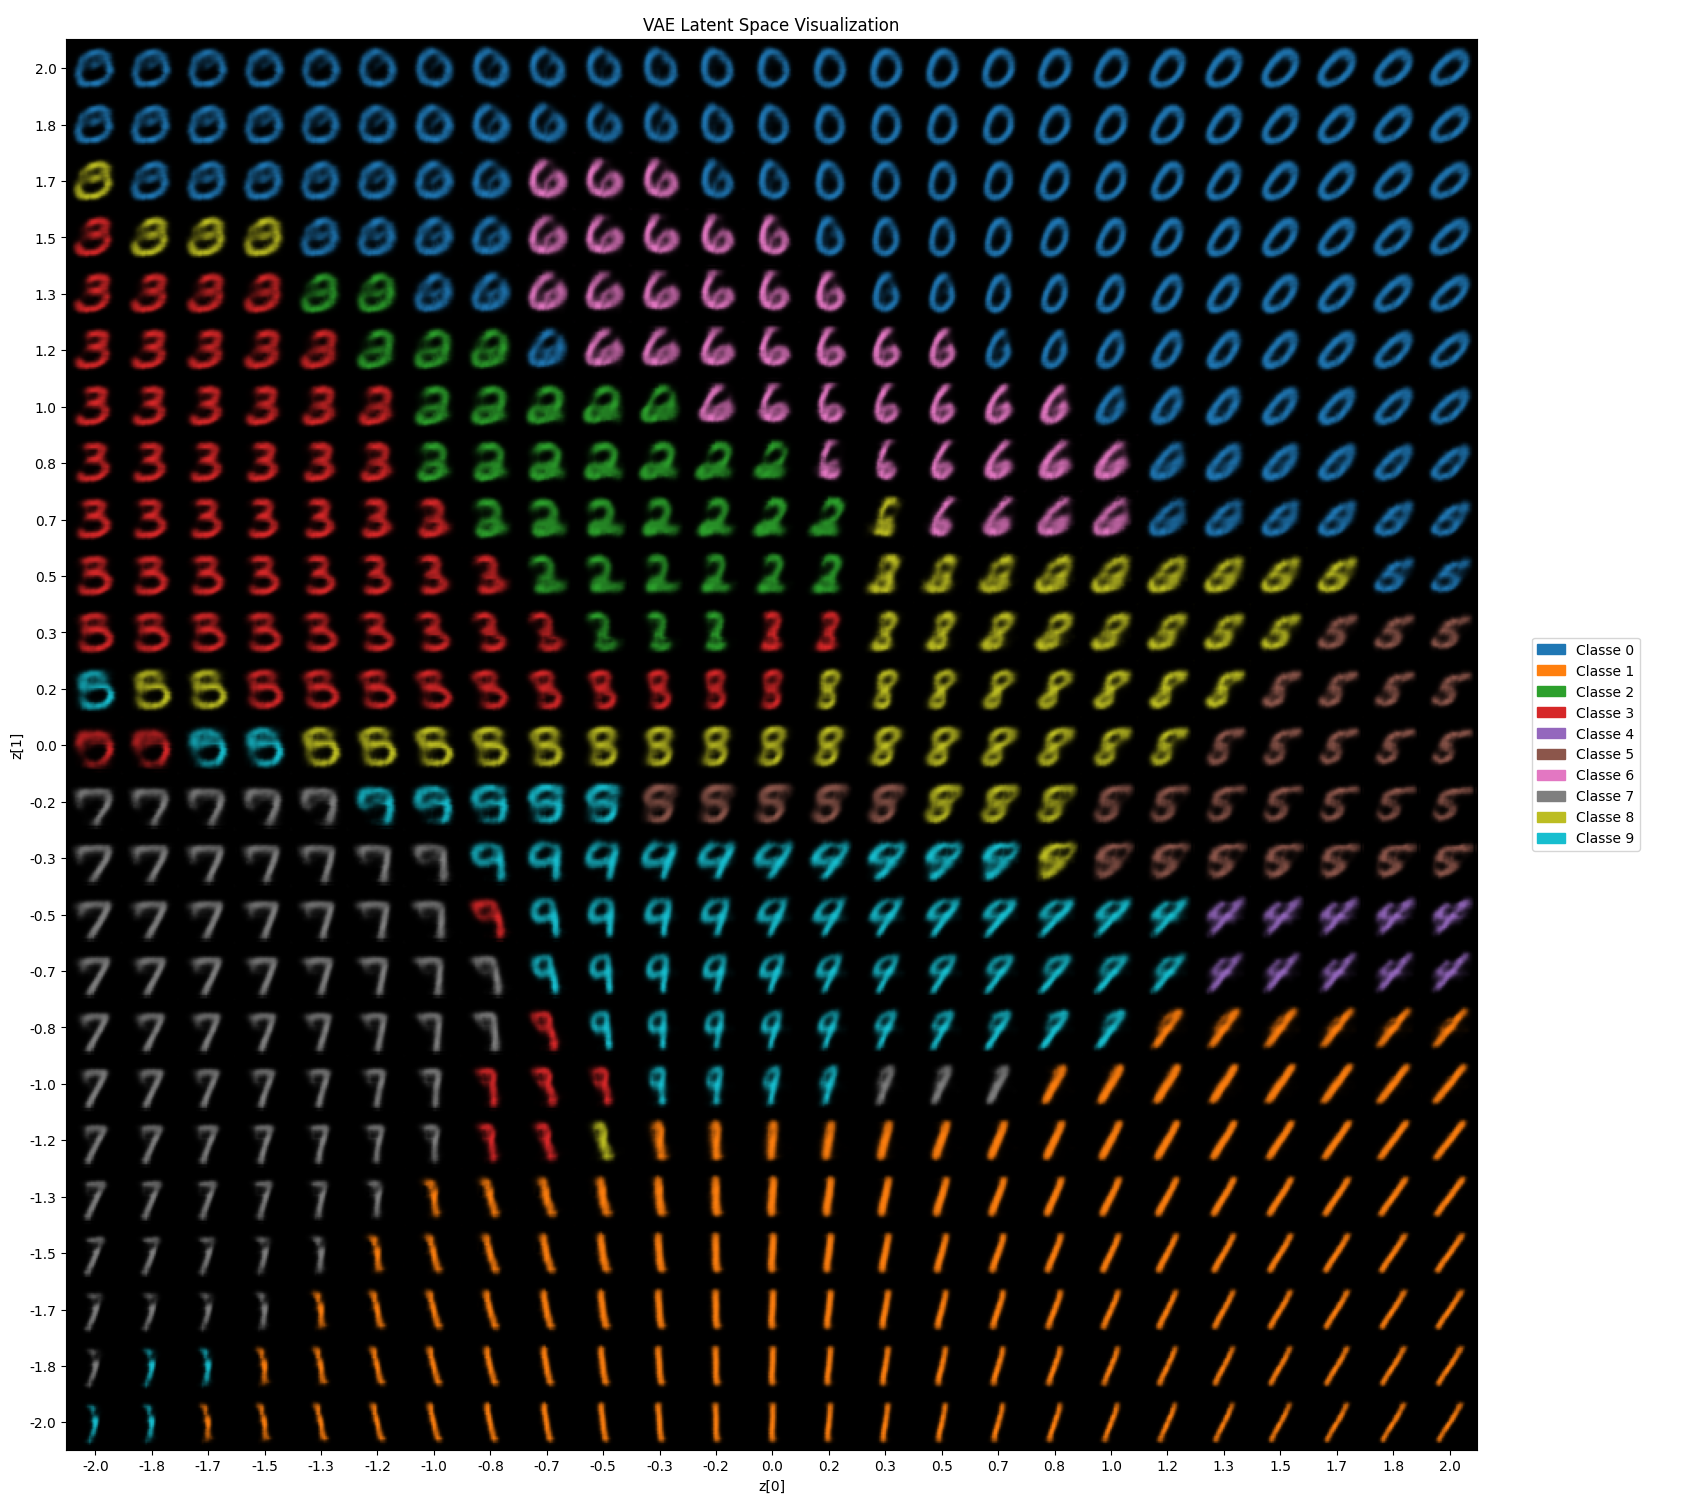

In [42]:
from matplotlib import cm
from torch import softmax
import matplotlib.patches as mpatches

classifier = torch.load(".checkpoint/model_checkpoint.pt",weights_only=False)

def plot_latent_space(model, scale=1.0, n=25, digit_size=32, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))
    value = []

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            softmax =  nn.Softmax()
            x_estimated = softmax(classifier(x_decoded))
            
            THRESHOLD = 0# soglia minima per la probabilità predetta

            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            x_est = x_estimated.cpu().squeeze()
            prob, pred = torch.max(x_est, dim=0)

            digit_np = digit.numpy()
            digit_norm = (digit_np - digit_np.min()) / (digit_np.max() - digit_np.min() + 1e-8)

            # Se la probabilità è bassa, immagine nera
            if prob.item() < THRESHOLD:
                digit_colored = np.zeros((digit_size, digit_size, 3))
            else:
                cmap = cm.get_cmap("tab10")
                color = cmap(pred.item())[:3]  # RGB
                digit_colored = np.stack([digit_norm * c for c in color], axis=-1)  # (H, W, 3)

            # Convert figure to RGB if not already
            if figure.ndim == 2:
                figure = np.stack([figure]*3, axis=-1)  # (H, W, 3)

            # Inserisci nel canvas
            x_start, x_end = j * digit_size, (j + 1) * digit_size
            y_start, y_end = i * digit_size, (i + 1) * digit_size
            figure[y_start:y_end, x_start:x_end] = digit_colored

    # Imposta figure e sottoplot
    fig, (ax_grid, ax_legend) = plt.subplots(1, 2, figsize=(figsize + 2, figsize), 
                                            gridspec_kw={'width_ratios': [figsize, 2]})

    # Mostra la griglia
    ax_grid.imshow(figure)
    ax_grid.set_title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    ax_grid.set_xticks(pixel_range)
    ax_grid.set_yticks(pixel_range)
    ax_grid.set_xticklabels(sample_range_x)
    ax_grid.set_yticklabels(sample_range_y)
    ax_grid.set_xlabel("z[0]")
    ax_grid.set_ylabel("z[1]")

    # Costruisci la legenda
    cmap = cm.get_cmap("tab10")
    legend_elements = [
        mpatches.Patch(color=cmap(i), label=f'Classe {i}') for i in range(10)
    ]

    ax_legend.legend(handles=legend_elements, loc='center')
    ax_legend.axis('off')  # Nasconde assi

    plt.tight_layout()
    plt.show()



plot_latent_space(model, scale=2)